This notebook computes the raw data used in the paper for comparisons with the test targets of Pasienski & DeMarco 2008.
In the current snapshot of the code, the computations using 1000 MRAF iterations can take several hours to run, and the 
calls to getStats can require several GB of RAM (mostly for the fourth target, the OR gate).  
You can omit the 1000 iteration calls if you just want to see the general idea.

In [1]:
using SLMTools
using Images, FFTW, JLD2, LinearAlgebra, IJuliaBell, FileIO, DSP
using SLMTools: wrap
import Interpolations: Linear

In [2]:
function boxEfficiency(F::LF{Intensity},roi::CartesianIndices)
    sum(F[roi].data)/sum(F.data)
end
function boxEfficiency(F::LF{<:Amplitude},roi::CartesianIndices)
    boxEfficiency(square(F),roi)
end
function boxEfficiency(F::LF{Intensity},roi::Matrix{Bool})
    sum(F.data[roi])/sum(F.data)
end
function boxEfficiency(F::LF{<:Amplitude},roi::Matrix{Bool})
    boxEfficiency(square(F),roi)
end

#-------------------------------- Targets ---------------------------------------------------------

function targetDiadem(L0::Lattice{2},radius::Real,thickness::Real,heightRatio::Real; center=[0.0,0.0],flambda::Real = 1.0)
    L,R,W,H = Tuple(L0[i] .- center[i] for i=1:2), radius, thickness, heightRatio-1
    ring = exp.(-(sqrt.(r2(L)) .- R).^2/(2*W^2))
    jewels = exp.(-(abs.(L[1]) .- R).^2/(2*W^2)) .* exp.(-L[2].^2/(2*W^2))'
    return LF{Intensity}(ring+H*jewels,L0,flambda) |> normalizeLF
end

function targetShuriken1(L0::Lattice{2},npoints::Real,Rinner::Real,Router::Real,blur::Real; theta0 = 0.0, center=[0.0,0.0],flambda::Real = 1.0)
    L,n,a2 = Tuple(L0[i] .- center[i] for i=1:2), npoints, Rinner^2
    b2 = a2 * sin(π/n)^2/(cos(π/n)^2 - a2/Router^2)
    thetas = (theta0 + 2π*j/n for j=0:n-1)
    shuriken = [all( (cos(t)*x + sin(t)*y)*abs(cos(t)*x + sin(t)*y)/a2 - (cos(t)*y - sin(t)*x)^2/b2 <= 1 for t in thetas) ? 1.0 : 0.0 for x in L[1], y in L[2]]
    return LF{Intensity}(imfilter(shuriken, Kernel.gaussian(blur)),L0,flambda) |> normalizeLF
end

function targetShuriken2(L0::Lattice{2},npoints::Real,Rinner::Real,Router::Real,blur::Real; theta0 = 0.0, center=[0.0,0.0],flambda::Real = 1.0)
    L,n = Tuple(L0[i] .- center[i] for i=1:2), npoints
    thetas = (theta0 + 2π*j/n for j=0:n-1)
    shuriken = [all( (cos(t)*x + sin(t)*y) < Rinner + abs(cos(t)*y - sin(t)*x) * (cos(π/n) - Rinner/Router)/sin(π/n) for t in thetas) ? 1.0 : 0.0 for x in L[1], y in L[2]]
    return LF{Intensity}(imfilter(shuriken, Kernel.gaussian(blur)),L0,flambda) |> normalizeLF
end

function targetRegPoly(L0::Lattice{2},npoints::Real,Rinner::Real,blur::Real; theta0 = 0.0, center=[0.0,0.0], flambda::Real = 1.0)
    L,n,r = Tuple(L0[i] .- center[i] for i=1:2), npoints, Rinner
    thetas = (theta0 + 2π*j/n for j=0:n-1)
    regPoly = [all( (cos(t)*x + sin(t)*y) <= r for t in thetas) ? 1.0 : 0.0 for x in L[1], y in L[2]]
    return LF{Intensity}(imfilter(regPoly, Kernel.gaussian(blur)),L0,flambda) |> normalizeLF
end

function Lbox(L::Lattice{2},xc::Real,yc::Real,h::Real,w::Real)
    return [ (abs(x-xc)<=h/2 && abs(y-yc)<=w/2) ? 1.0 : 0.0 for x in L[1], y in L[2]]
end

function targetORGate(L::Lattice{2},params::Dict,blur::Real; center=[0.0,0.0], flambda::Real=1.0)
    # params should have fields: wWire, wMain, wHole, wTail
                                # hMain, hHole, hPad, hTail, hFoot
                                # lMain, lFoot, lTail, lWhiskers
                                # zMain, zPad
    ww,wm,wh,wt,hm,hh,hp,ht,hf,lm,lf,lt,lw,zm,zp = params[:wWire],params[:wMain],params[:wHole],params[:wTail],
        params[:hMain],params[:hHole],params[:hPad],params[:hTail],params[:hFoot],params[:lMain],params[:lFoot],params[:lTail],params[:lWhiskers],params[:zMain],params[:zPad]
    H = hm+lm+lf+hf
    W = lt+wm/2+lt+wt
    x0,y0 = H/2 - hf - lf, W/2 - wt - lt    # Central vertex
    xf, xm, xh, yt = x0+lf+hf/2, x0 - lm - hm/2, x0 - lm - ww - hh/2, y0 + lt + wt/2
    main = Lbox(L,xf,y0,hf,wm) + Lbox(L,xm,y0,hm,wm) + Lbox(L,x0,yt,ht,wt) +    # Big boxes
            Lbox(L,(xf+xm)/2,y0,xf-xm,ww) + Lbox(L,x0,(y0+yt)/2,ww,(yt-y0)) + # Connecting wires
            Lbox(L,xh,y0,ww,wm+2*lw)    # Whiskers
    main = (x-> (iszero(x) ? 0.0 : 1.0)).(main) .* zm
    pad = Lbox(L,xh,y0,hp,wm) * (zp-zm)
    hole = Lbox(L,xh,y0,hh,wh)
    return LF{Intensity}( imfilter((main+pad) .* (1.0 .- hole), Kernel.gaussian(blur)), L,flambda) |> normalizeLF
end                    

function targetORGate(L::Lattice{2},scale::Real,blur::Real; center=[0.0,0.0], flambda::Real=1.0)
    # Uses default ratios for the OR gate.  scale=1 means the OR gate height is the same as the height of the lattice L. 
    # You probably want scale ~ 0.7 or so. 
    d0 = Dict(:wWire=>10, :wMain=>70, :wHole=>25, :wTail=>50,
                    :hMain=>120, :hHole=>70, :hPad=>15, :hTail=>50, :hFoot=>50,
                    :lMain=>40, :lFoot=>50, :lTail=>55, :lWhiskers=>35,
                    :zMain=>1.0, :zPad=>1.33)
    r = (L[1][end]-L[1][1])/(d0[:hMain]+d0[:lMain]+d0[:lFoot]+d0[:hFoot])
    d1 = Dict(k=>d0[k]*r*scale for k in keys(d0))
    return targetORGate(L,d1,blur;center=center,flambda=flambda)
end

function targetSquid(L0::Lattice{2},radius::Real,thickness::Real,hGap::Real,hTail::Real,heightRatio::Real,blur::Real; center=[0.0,0.0],flambda::Real = 1.0)
    L,R,W,G,T,H = Tuple(L0[i] .- center[i] for i=1:2), radius, thickness, hGap, hTail, heightRatio
    ring = exp.(-(sqrt.(r2(L)) .- R).^2/(2*W^2))
    tail = [ (R+T>=abs(x)>=R ? 1.0 : 0.0) for x in L[1] ] .* exp.( -L[2].^2 ./ (2*W^2) )'
    main = [max(ring[I],tail[I]) for I in CartesianIndices(size(ring))]
    reducer = 1.0 .- Lbox(L,0.0,0.0,G,2*R+10*W)*(1-H)
    return LF{Intensity}(imfilter(main .* reducer, Kernel.gaussian(blur)),L0,flambda) |> normalizeLF
end

function targetQtip(L0::Lattice{2},wireLength::Real,thickness::Real,radius::Real,blur::Real; center=[0.0,0.0],flambda::Real = 1.0)
    L,H,W,R = Tuple(L0[i] .- center[i] for i=1:2), wireLength, thickness, radius
    wire = (x-> (-H/2<=x<=H/2 ? 1.0 : 0.0)).(L[1]) .* exp.( -L[2].^2 ./ (2*W^2) )'      #Lbox(L,0.0,0.0,H,W)
    tips = exp.(-(abs.(L[1]) .- H/2).^2 ./(2*R^2)) .* exp.(-L[2].^2 ./ (2*R^2))'
    main = [max(wire[I],tips[I]) for I in CartesianIndices(size(wire))]
    main = imfilter(main, Kernel.gaussian(blur))
    return LF{Intensity}(main,L0,flambda)
end

#----------------------------- MRAF ---------------------------------------

function mraf2(U::LF{Modulus,<:Real,N}, V::LF{Modulus,<:Real,N}, nit::Integer, Φ0::LF{<:Phase,<:Number,N}, mask, m::Real) where {N}
    # Runs nit number of iterations of MRAF on the distributions specified by U and V.  Φ0 is a starting phase guess.
    ldq(U, V), elq(U, Φ0)                              # Check for compatibility of the lattices

    U = normalizeLF(U)
    V = normalizeLF(V)
    guess = U * wrap(Φ0)
    R = sqrt(sum(square(sft(guess)).data))      # This compensates non-unitarity of sft.

    for i = 1:nit
        out = sft(guess)
        out.data[mask] = phasor.(out.data[mask]) .* V.data[mask] * m
        out.data[.~mask] .*= (1-m)/R
        guess = phasor(isft(out)) * U
    end
    return phasor(guess)
end


#------- Convenience functions for matching the Pasienski and DeMarco paper -------

function embed(f::LF{S,T,N},L::Lattice{N},offset::CartesianIndex{N}) where {S,T,N}
    data = zeros(T,length.(L))
    data[offset .+ CartesianIndices(size(f))] .= f.data
    return LF{S}(data,L,f.flambda)
end

function embed(f::LF{S,T,N},L::Lattice{N}) where {S,T,N}
    d = (length.(L) .- length.(f.L)) .÷ 2
    return embed(f,L,CartesianIndex(d))
end

function centeredIntLat(ns::NTuple{N,Integer}) where N
    ls = .-(ns .÷ 2)
    us = (ns .- 1) .÷ 2
    return ((ls[i]:us[i] for i=1:N)...,)
end

function centeredIndices(width::NTuple{N,Integer},gridsize::NTuple{N,Integer},offset::CartesianIndex{N}) where N
    return offset .+ CartesianIndex((gridsize .- width) .÷ 2) .+ CartesianIndices(width)
end
function centeredIndices(width::NTuple{N,Integer},gridsize::NTuple{N,Integer}) where N
    return CartesianIndex((gridsize .- width) .÷ 2) .+ CartesianIndices(width)
end

#--------------------- MRAF tuning --------------------------------------------------------

function mrafTuneForEta(U::LF{Modulus,<:Real,N}, V::LF{Modulus,<:Real,N}, nit::Integer, Φ0::LF{<:Phase,<:Number,N}, roi::CartesianIndices, etaTarget::Real, tol::Real) where {N}
    ml = 0.0
    mu = 1.0
    m = 0.5
    phi = mraf(U,V,nit,Φ0,roi,m)
    eta = boxEfficiency(sft(U*phi),roi)
    while abs(eta - etaTarget) > tol
        if eta > etaTarget
            mu = m
        else
            ml = m
        end
        m = (mu+ml)/2
        phi = mraf(U,V,nit,Φ0,roi,m)
        eta = boxEfficiency(sft(U*phi),roi)
    end
    return m
end

function mrafTuneForEps(U::LF{Modulus,<:Real,N}, V::LF{Modulus,<:Real,N}, nit::Integer, Φ0::LF{<:Phase,<:Number,N}, roi::CartesianIndices, mMin::Real, tol::Real; m0Max=1.0) where {N}
    ms = (mMin,(m0Max+mMin)/2,m0Max)
    phis = (m->mraf(U,V,nit,Φ0,roi,m)).(ms)
    ϵs = (phi->SchroffError(square(V),square(sft(U*phi)))).(phis)
    println(ms)
    i = 0
    while (min(ms[2]-ms[1],ms[3]-ms[2]) > tol) && (i < 100)
        if ϵs[3] > ϵs[2] > ϵs[1]
            ms = (max(mMin,2*ms[1]-ms[2]),max(ms[1],(ms[2]+mMin)/2),ms[2])
            ϵs = (SchroffError(square(V),square(sft(U*mraf(U,V,nit,Φ0,roi,ms[1])))), ϵs[1], ϵs[2])
        elseif ϵs[1] > ϵs[2] > ϵs[3]
            ms = (ms[2],min(ms[3],(1.0+ms[2])/2),min(2*ms[3]-ms[2],1.0))
            ϵs = (ϵs[2], ϵs[3], SchroffError(square(V),square(sft(U*mraf(U,V,nit,Φ0,roi,ms[3])))))
        else
            mt1 = (ms[1]+ms[2])/2
            mt2 = (ms[2]+ms[3])/2
            ϵt1 = SchroffError(square(V),square(sft(U*mraf(U,V,nit,Φ0,roi,mt1))))
            ϵt2 = SchroffError(square(V),square(sft(U*mraf(U,V,nit,Φ0,roi,mt2))))
            if ϵt1 < ϵt2
                ms = (ms[1],mt1,ms[2])
                ϵs = (ϵs[1],ϵt1,ϵs[2])
            else
                ms = (ms[2],mt2,ms[3])
                ϵs = (ϵs[2],ϵt2,ϵs[3])
            end
        end
        println(ms)
        i += 1
    end
    if ϵs[1] < min(ϵs[2],ϵs[3])
        return ms[1]
    elseif ϵs[2] < ϵs[3]
        return ms[2]
    else
        return ms[3]
    end
end

function mrafTuneForEps(U::LF{Modulus,<:Real,N}, V::LF{Modulus,<:Real,N}, nit::Integer, Φ0::LF{<:Phase,<:Number,N}, roi::Matrix{Bool}, mMin::Real, tol::Real; m0Max=1.0) where {N}
    ms = (mMin,(m0Max+mMin)/2,m0Max)
    phis = (m->mraf2(U,V,nit,Φ0,roi,m)).(ms)
    ϵs = (phi->SchroffError(square(V),square(sft(U*phi)))).(phis)
    println(ms)
    i = 0
    while (min(ms[2]-ms[1],ms[3]-ms[2]) > tol) && (i < 100)
        if ϵs[3] > ϵs[2] > ϵs[1]
            ms = (max(mMin,2*ms[1]-ms[2]),max(ms[1],(ms[2]+mMin)/2),ms[2])
            ϵs = (SchroffError(square(V),square(sft(U*mraf2(U,V,nit,Φ0,roi,ms[1])))), ϵs[1], ϵs[2])
        elseif ϵs[1] > ϵs[2] > ϵs[3]
            ms = (ms[2],min(ms[3],(1.0+ms[2])/2),min(2*ms[3]-ms[2],1.0))
            ϵs = (ϵs[2], ϵs[3], SchroffError(square(V),square(sft(U*mraf2(U,V,nit,Φ0,roi,ms[3])))))
        else
            mt1 = (ms[1]+ms[2])/2
            mt2 = (ms[2]+ms[3])/2
            ϵt1 = SchroffError(square(V),square(sft(U*mraf2(U,V,nit,Φ0,roi,mt1))))
            ϵt2 = SchroffError(square(V),square(sft(U*mraf2(U,V,nit,Φ0,roi,mt2))))
            if ϵt1 < ϵt2
                ms = (ms[1],mt1,ms[2])
                ϵs = (ϵs[1],ϵt1,ϵs[2])
            else
                ms = (ms[2],mt2,ms[3])
                ϵs = (ϵs[2],ϵt2,ϵs[3])
            end
        end
        println(ms)
        i += 1
    end
    if ϵs[1] < min(ϵs[2],ϵs[3])
        return ms[1]
    elseif ϵs[2] < ϵs[3]
        return ms[2]
    else
        return ms[3]
    end
end

function haloRoi(target::LF{Intensity,T,2},dx::Real,thresh::Real) where T
    tile = CartesianIndices((-dx:dx,-dx:dx))
    s = thresh * maximum(target.data)
    CI = CartesianIndices(size(target))
    return [(maximum(target.data[intersect(tile .+ I,CI)]) >= s) for I in CI]
end
function haloRoi(target::LF{Intensity,T,2},dx::Real,thresh::Real,roi::CartesianIndices) where T
    z = zeros(size(target))
    z[roi] = haloRoi(target[roi],dx,thresh)
    return z
end

function getStats(inputBeam::LF{Modulus},targetBeam::LF{Intensity},phase::LF{ComplexPhase},roiLook,roiEta,downsampleFactor=1)
    println(SchroffError(targetBeam,square(sft(inputBeam*phase)),0.1), ", " , boxEfficiency(square(sft(inputBeam*phase)),roiEta))
    return look(downsample(square(sft(inputBeam*phase))[roiLook],downsampleFactor))
end
function getStats(inputBeam::LF{Intensity},targetBeam::LF{Intensity},phase::LF{ComplexPhase},roiLook,roiEta,downsampleFactor=1)
    getStats(sqrt(inputBeam),targetBeam,phase,roiLook,roiEta,downsampleFactor)
end

function linquadcone(L::Lattice{2},lin::Real,quad::Real,cone::Real;mu::Real=0.0,alpha::Real=0.5,phi0=0.0,flambda::Real=1.0,toRads::Bool=true)
    ϕlin = ldot((lin*step(L[1])*cos(mu),lin*step(L[2])*sin(mu)),L)
#    ϕquad = r2(L .* (sqrt.((1-alpha,alpha)) .* sqrt(2) ./ (step.(L)))) * quad
    ϕquad = 2quad .* ( (1-alpha) .* (L[1] ./ step(L[1])).^2 .+ ( alpha .* (L[2] ./ step(L[2])).^2 )' )
    ϕcone = sqrt.(r2(L .* (1 ./ step.(L)))) * cone
    return LF{RealPhase}((ϕlin+ϕquad+ϕcone) * (toRads ? 1/(2π) : 1),L,flambda)
end

function avgFilter(f::LF{S,T,N},s::Int) where {S<:FieldVal,T,N}
    return LF{Intensity}(conv(f.data,ones((s for i=1:N)...) ./ s^2)[CartesianIndices(size(f)) .+ CartesianIndex(((s-1)÷2 for i=1:N)...)],f.L,f.flambda)
end
function lfShift(f::LF{S,T,N},shift::NTuple{N,Int}) where {S<:FieldVal,T,N}
    return LF{S,T,N}(circshift(f.data,shift),f.L,f.flambda)
end

function colorCompare(im1::Matrix{Gray{Float64}},im2::Matrix{Gray{Float64}};cs = (1,2))
    z = im1 .* 0
    z = [z,z,z]
    z[cs[1]] = im1
    z[cs[2]] = im2
    img = cat(z[1],z[2],z[3]; dims=3)
    nimg = permutedims(img,(3,1,2))
    return colorview(RGB,nimg)
end

function lookSix(lfs::NTuple{6,LF},rois::NTuple{6,CartesianIndices},ds::NTuple{6,Int})
    ls = Tuple(look(downsample(lfs[i][rois[i]],ds[i])) for i=1:6)
    vcat(hcat(ls[1:3]...),hcat(ls[4:6]...))
end

function lookSix(ims::NTuple{6,Matrix{Gray{Float64}}},rois::NTuple{6,CartesianIndices},ds::NTuple{6,Int})
    ls = Tuple(coarsen(ims[i][rois[i]],ds[i]) for i=1:6)
    vcat(hcat(ls[1:3]...),hcat(ls[4:6]...))
end
function lookSix(ims::NTuple{6,Matrix{Gray{Float64}}},ds::NTuple{6,Int})
    ls = Tuple(coarsen(ims[i],ds[i]) for i=1:6)
    vcat(hcat(ls[1:3]...),hcat(ls[4:6]...))
end

function coarsen(x::AbstractArray{Gray{Float64},N}, ns::NTuple{N,Int}; reducer=(x::AbstractArray -> sum(x) / length(x[:]))) where N
    # This is also a downsampler, but it averages over superpixels, rather than interpolating. 
    # Downsamples an array to a grid that is ns[i] times coarser in dimension i, i.e. a grid downsampled by ns, 
    # reducing superpixels via the supplied function reducer. 
    sx = size(x)
    if sx .% ns != size(x) .* 0
        throw(DomainError((sx, ns), "coarsen: Downsample factors ns do not divide the size of array x."))
    end
    box = CartesianIndices(ns) .- CartesianIndex((1 for i = 1:N)...)
    CI = CartesianIndices(((1:ns[i]:size(x)[i] for i = 1:N)...,))
    return [reducer(x[I.+box]) for I in CI]
end

function coarsen(x::AbstractArray{Gray{Float64},N}, n::Int; reducer=(x::AbstractArray -> sum(x) / length(x[:]))) where N
    # Downsamples an array to a grid that is n times coarser, i.e. a grid downsampled by n, reducing superpixels via the supplied function reducer. 
    return coarsen(x, ((n for i = 1:N)...,); reducer=reducer)
end

function scaleSix(im::Matrix{Gray{Float64}},scales::NTuple{6,Real})
    CI = CartesianIndices((size(im,1)÷2,size(im,2)÷3))
    sx = CartesianIndex(size(im,1)÷2,0)
    sy = CartesianIndex(0,size(im,2)÷3)
    return vcat(hcat(im[CI],im[CI .+ sy],im[CI .+ sy .+ sy]),hcat(im[CI .+ sx],im[CI .+ sy .+ sx],im[CI .+ sy .+ sy .+ sx]))
end

#-------------------------- Digitization of phase levels
function adcPhase(f::LF{ComplexPhase},bits=8)
    phi = round.((angle.(f.data) .+ π) .* ((2^bits-1) / (2π))) ./ (2^bits-1) .- π
    return LF{ComplexPhase}(exp.(2π*im*phi),f.L,f.flambda)
end

adcPhase (generic function with 2 methods)

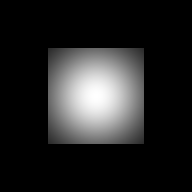

In [3]:
# Generate input beam
N2 = 768
Lslm = centeredIntLat((N2,N2))
Lbig = centeredIntLat((2*N2,2*N2))
dLslm = dualShiftLattice(Lslm)
dLbig = dualShiftLattice(Lbig)
I2 = sqrt(embed(lfGaussian(Intensity,Lslm,565/2),Lbig))
roiIn = centeredIndices((N2,N2),(2N2,2N2))
look(downsample(square(I2),8))

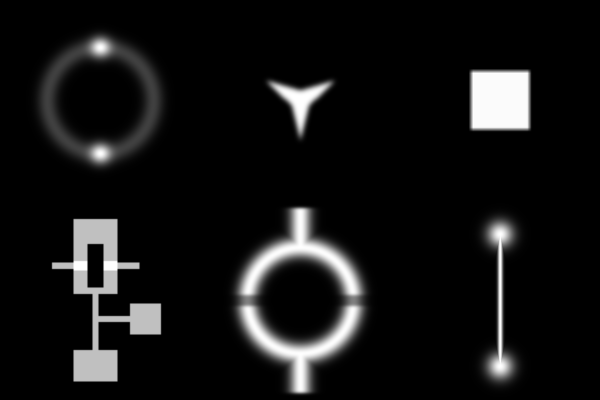

In [4]:
##### Generate targets
L200 = centeredIntLat((200,200))
L400 = centeredIntLat((400,400))
L800 = centeredIntLat((800,800))

diadem = targetDiadem(L200,53,14/2,4)
shuriken = targetShuriken2(L200,3,40*sin(14*pi/180)/sin(106*pi/180),40,5/2, theta0 = π)
fourgon = avgFilter(targetRegPoly(L200,4,2*58/2+0.001,0),9)
orgate = targetORGate(L400,325/399,1.0)
squid = targetSquid(L200,53,7,10,(185-2*53)/2,0.5,1.5)
qtip = targetQtip(L400,264,3.5,17.6,0)

# Generate centered targets on the lattice we actually use for computations
targets0 = (x->embed(x,dLbig)).((diadem,shuriken,fourgon,orgate,squid,qtip))
# Shift targets 2 and 3
s2 = (round(Int,-37/sqrt(8)),round(Int,-37/sqrt(8)))
s3 = (0,-63)
targets = (targets0[1],lfShift(targets0[2],s2),lfShift(targets0[3],s3),targets0[4],targets0[5],targets0[6])

# Region of interest and downsample factor for looking at images
CI200 = CartesianIndices(L200) .+ CartesianIndex(N2+1,N2+1)
CI400 = CartesianIndices(L400) .+ CartesianIndex(N2+1,N2+1)
trois = (CI200,CI200 .+ CartesianIndex(s2),CI400 .+ CartesianIndex(s3),CI400,CI200,CI400)
ds = (1,1,2,2,1,2)
lookSix(targets,trois,ds)

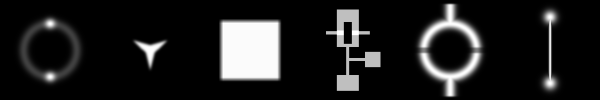

In [5]:
# Crop and downsample for OT, to avoid memory overload/very slow sinkhorn evaluation
roiIn2 = centeredIndices((N2+32,N2+32),(2N2,2N2))
roi200 = centeredIndices((200,200),(2N2,2N2))
roi400 = centeredIndices((400,400),(2N2,2N2))
rois_ot2 = (roi200,roi200 .+ CartesianIndex(s2),roi200 .+ CartesianIndex(s3),roi400,roi200,roi400);
downsampleFactors = (2,2,2,4,2,4)
# Generate reduced size targets for OT. 
dsTargets = ((downsample(targets[i][rois_ot2[i]],downsampleFactors[i]) for i=1:6)...,)
look(dsTargets...)

In [6]:
# OT phases
Φots = ((upsample(otPhase(downsample(square(I2)[roiIn2],8),dsTargets[i],0.001),I2.L,bc=Linear()) |> SLMTools.wrap for i=1:6)...,);


┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport C:\Users\stron\.julia\packages\OptimalTransport\ztQxB\src\entropic\sinkhorn_solve.jl:103
┌ Warning: Sinkhorn algorithm (1000/1000): not converged
└ @ OptimalTransport C:\Users\stron\.julia\packages\OptimalTransport\ztQxB\src\entropic\sinkhorn_solve.jl:103


In [7]:
# Tight MRAF rois
rois2 = [zeros(Bool,2N2,2N2) for i=1:6]
rois2[1][trois[1]] .= [25^2 - 0.1 < sum((Tuple(I) .- Tuple(trois[1][1] + trois[1][end]) .÷2).^2) < 81^2+0.1 for I in trois[1]]
rois2[2][trois[2]] .= [sum((Tuple(I) .- Tuple(trois[2][1] + trois[2][end]) .÷2).^2) < 40^2+0.1 for I in trois[2]]

w = (75-1)
tmp = CartesianIndices((-w:w,-w:w)) .+ CartesianIndex(s3...) .+ CartesianIndex(N2,N2)
rois2[3][tmp] .= true;

rois2[4] = haloRoi(targets[4],10,0.1,trois[4]);
rois2[5] = haloRoi(targets[5],10,0.1,trois[5]);
rois2[6] = zeros(Bool,2N2,2N2); rois2[6][trois[6]] .= [ (sum((Tuple(I) .- Tuple(trois[1][1] + trois[1][end]) .÷2 .- (132,0)).^2) < 53^2+0.1) ||
                                                       (sum((Tuple(I) .- Tuple(trois[1][1] + trois[1][end]) .÷2 .+ (132,0)).^2) < 53^2+0.1) ||
                                                       (abs.(Tuple(I) .- Tuple(trois[1][1] + trois[1][end]) .÷2)[2] < 13) for I in trois[6]];


0.0884737407804331, 0.9890021154362444
0.18684487386725085, 0.987408784610974
0.23661018576687695, 0.9931337369315046
0.41219984556011224, 0.9716377983729455
0.1593705671689805, 0.9892589963692453
0.11361065538366266, 0.9881112008001096


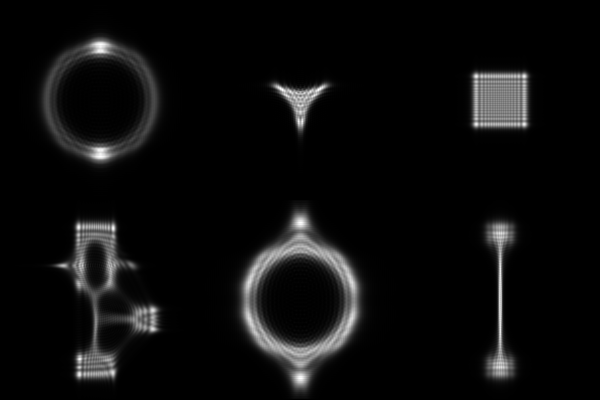

In [8]:
fig_ot = lookSix(Tuple(getStats(I2,targets[i],Φots[i],trois[i],rois2[i]) for i=1:6),ds)

In [9]:
# Mixing parameters for MRAF, tuned by hand. 
ms = (0.459765625, 0.455, 0.455, 0.42109375, 0.48, 0.4802734375);

In [10]:
Φmrafs100 = ((mraf2(I2,sqrt(targets[i]),100,Φots[i],rois2[i],ms[i]) for i=1:6)...,);

0.004646908615161555, 0.72528351730129
0.016391853710637356, 0.6929300866583387
0.014478938927250924, 0.6954005138020929
0.01619383898387167, 0.5288254730077304
0.00848874413573815, 0.8539328407951942
0.01014975735010063, 0.8507375815033601


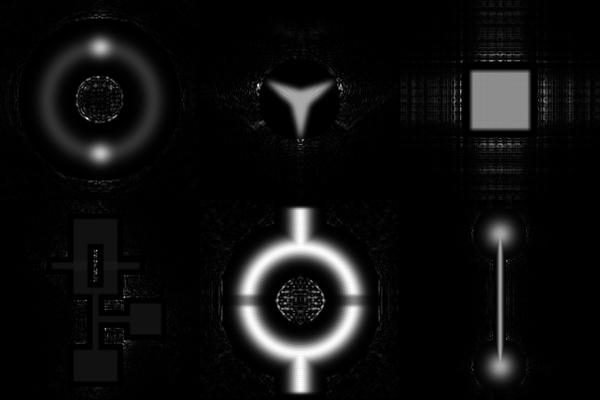

In [11]:
fig_mraf100 = lookSix(Tuple(getStats(I2,targets[i],Φmrafs100[i],trois[i],rois2[i]) for i=1:6),ds)

In [12]:
Φmrafs1000 = ((mraf2(I2,sqrt(targets[i]),900,Φmrafs100[i],rois2[i],ms[i]) for i=1:6)...,);

0.0016930308553241428, 0.7242358228264182
0.009584828664599919, 0.6941332249470756
0.007519423570624048, 0.6966045690929543
0.005451030769442845, 0.5290314340775892
0.003463222996015128, 0.8516893019023073
0.002968289754396103, 0.8482019262916484


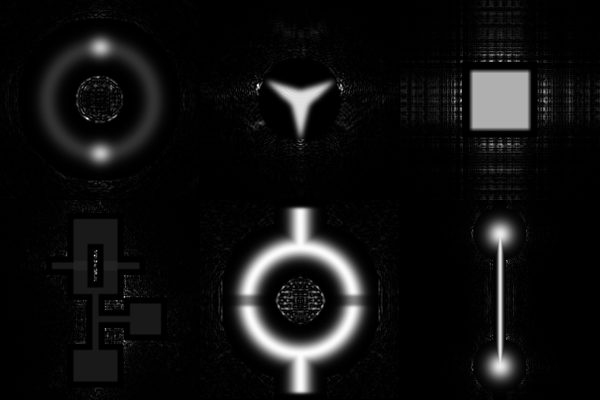

In [13]:
fig_mraf1000 = lookSix(Tuple(getStats(I2,targets[i],Φmrafs1000[i],trois[i],rois2[i]) for i=1:6),ds)

In [14]:
# GS phases. 
Φgs100 = ((gs(I2,sqrt(targets[i]),100,Φots[i]) for i=1:6)...,);

0.06173633527405259, 0.992389920545584
0.13271777777720395, 0.989955707852616
0.18529280989954372, 0.9949217467844412
0.22504448898138918, 0.9857769689213928
0.09837904190802757, 0.9930133907351929
0.07402757062524923, 0.9885382529127242


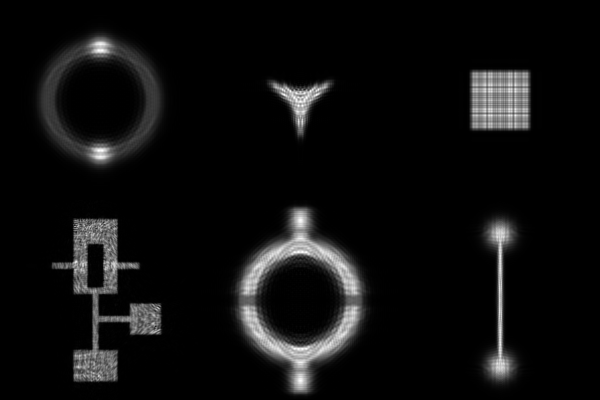

In [15]:
fig_gs100 = lookSix(Tuple(getStats(I2,targets[i],Φgs100[i],trois[i],rois2[i]) for i=1:6),ds)

In [16]:
Φgs1000 = ((gs(I2,sqrt(targets[i]),900,Φgs100[i]) for i=1:6)...,);

0.06095866555703879, 0.992491899280319
0.13249881694724985, 0.9898914511706702
0.16648249135810603, 0.9951875414886479
0.22192241346146485, 0.9859770512036694
0.09792060047556188, 0.9930443532159284
0.07314907802006668, 0.9882884930103655


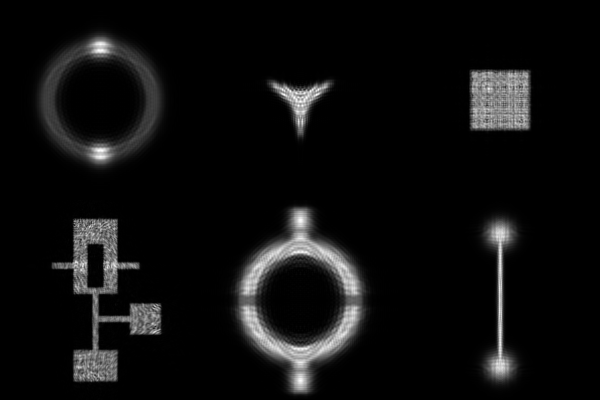

In [17]:
fig_gs1000 = lookSix(Tuple(getStats(I2,targets[i],Φgs1000[i],trois[i],rois2[i]) for i=1:6),ds)

In [18]:
#= This runs MRAF with a much wider region of interest.  The mixing parameters are not optimized for 
this case, but they still work pretty well.  =#
Φmrafs1000_loose = ((mraf(I2,sqrt(targets[i]),1000,Φots[i],trois[i],ms[i]) for i=1:6)...,);

0.0013854729627574996, 0.7241185724343737
0.015196176963195912, 0.6909277448319914
0.009513970105494228, 0.6956098006660304
0.005520660624689764, 0.5288508071553343
0.004031926795546988, 0.8510645882509286
0.005042002563454756, 0.8468027521232396


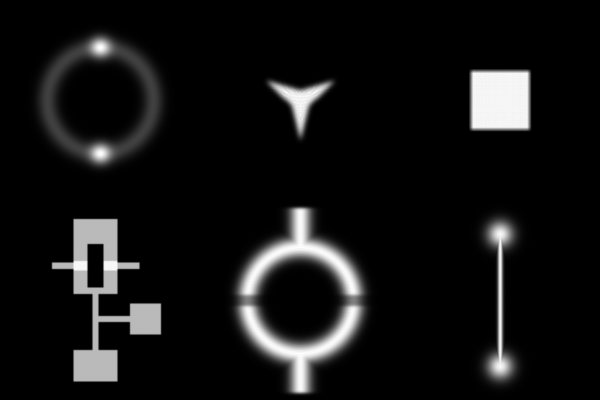

In [19]:
fig_mrafs1000_loose = lookSix(Tuple(getStats(I2,targets[i],Φmrafs1000_loose[i],trois[i],rois2[i]) for i=1:6),ds)

In [20]:
jldsave("target_comparisons.jld2"; I2, targets, trois, rois2, Φots, Φmrafs100, Φmrafs1000, Φgs100, Φgs1000, Φmrafs1000_loose);

In [21]:
# Finally, we digitize outputs for comparison to Pasienski & DeMarco 2008.  This doesn't affect the final numbers very much.

In [22]:
Φmrafs1000_digitized = adcPhase.(Φmrafs1000);

0.0017186110071225886, 0.7242112333416091
0.009594201856752005, 0.6941041016685314
0.007568804348339805, 0.696574819909711
0.0056054100766797, 0.5289919989198152
0.00350254361951088, 0.8516512075906475
0.0030037542234634894, 0.848146870716338


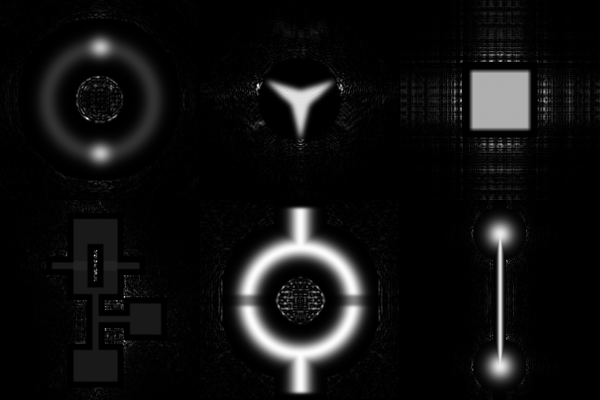

In [23]:
lookSix(Tuple(getStats(I2,targets[i],Φmrafs1000_digitized[i],trois[i],rois2[i]) for i=1:6),ds)

In [24]:
Φgs1000_digitized = adcPhase.(Φgs1000);

0.060960296861764664, 0.9924426079368895
0.13250743440887866, 0.9898409131179743
0.1664816050163772, 0.9951380947931037
0.22191587333472143, 0.9859270755270453
0.09793635898402456, 0.9929951098515832
0.07314639446059176, 0.9882403396702101


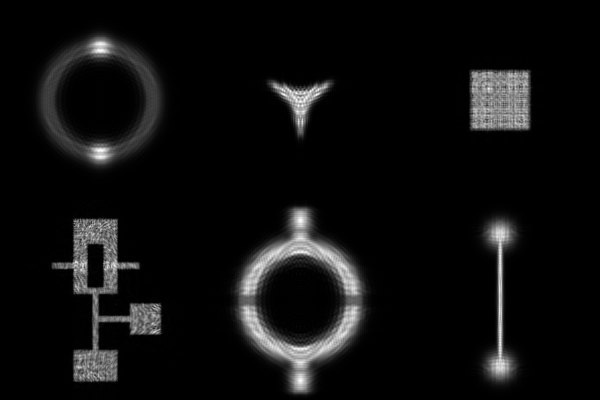

In [25]:
lookSix(Tuple(getStats(I2,targets[i],Φgs1000_digitized[i],trois[i],rois2[i]) for i=1:6),ds)

In [26]:
#= The measure regions used in Pasienski & DeMarco 2008 are slightly different than those used above
in the case of targets 1 and 3.  For target 1, they use an annulus of inner radius 44 and outer radius 62.  
For target 3 they use a centered square of side length 114.  The following cells compute the RMS error
using these measure regions.  In both cases, the result is similar to that computed above (slightly less, 
in fact), where measure region was set to all pixels with target intensity at least a 10% of its max value. 
=#

In [27]:
roi1_signal = [44^2-0.1 < sum((Tuple(I) .- Tuple(trois[1][1] + trois[1][end]) .÷2).^2) < 62^2+0.1 for I in trois[1]];
x = targets[1][trois[1]].data[roi1_signal];
x ./= sum(x)
y = square(sft(I2*Φmrafs1000_digitized[1]))[trois[1]].data[roi1_signal];
y ./= sum(y)
nPixels = sum(roi1_signal)
sqrt(sum( (x-y).^2/x.^2 )/nPixels)

0.0016409507350808588

In [28]:
roi3_signal = [(-57-0.1 < (Tuple(I) .- Tuple(trois[3][1] + trois[3][end]) .÷2)[1] < 57+0.1) &&
    (-57-0.1 < (Tuple(I) .- Tuple(trois[3][1] + trois[3][end]) .÷2)[2] < 57+0.1) for I in trois[3]];
x = targets[3][trois[3]].data[roi3_signal];
x ./= sum(x)
y = square(sft(I2*Φmrafs1000_digitized[3]))[trois[3]].data[roi3_signal];
y ./= sum(y)
nPixels = sum(roi3_signal)
sqrt(sum( (x-y).^2/x.^2 )/nPixels)

0.003881000370616696